In [5]:
%matplotlib inline

import powergama
import powergama.powergim as pgim
import powergama.GIS
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rnd

#scenario=''
scenario='4_1'
#realisation='4_1'
realisation=None
rnd.seed(2016) #fixed seed  to be able to recreate results - debugging
gridf='data'

grid_data = powergama.GridData()
if realisation is not None:
    print("Investigating specified scenario realisation: {}".format(realisation))
    gridf='{}_{}'.format(gridf,realisation)
grid_data.readSipData(nodes = gridf+"/dog_nodes.csv",
                  branches = gridf+"/dog_branches.csv",
                  generators = gridf+"/dog_generators.csv",
                  consumers = gridf+"/dog_consumers.csv")

# Profiles:
if True:
    print("\n<> Loading time-series sample...")
    samplesize = 100
    grid_data.readProfileData(filename= "data/timeseries_sample_100_rnd2016.csv",
                              timerange=range(samplesize), timedelta=1.0)
if False:
    # create new sample
    grid_data.readProfileData(filename = "data/timeseries_doggerbank.csv",
                              timerange = range(8760), timedelta = 1.0)

    print("\n<> Sampling...\n")
    samplingmethod = 'kmeans'
    samplesize = 100
    profiledata_sample = pgim.sampleProfileData(data=grid_data,
                                                samplesize=samplesize,
                                                sampling_method=samplingmethod)
    profiledata_sample.to_csv("data/timeseries_sample_100_rnd2016.csv")
    grid_data.timerange = range(profiledata_sample.shape[0])
    grid_data.profiles = profiledata_sample

sip = pgim.SipModel()
dict_data = sip.createModelData(grid_data,
                                datafile='data/dog_data_irpwind.xml',
                                maxNewBranchNum=5,maxNewBranchCap=5000)
if scenario=="":
    pass
elif scenario=="4_3":
    dict_data['powergim']['genCapacity2'][9] = 0 #9,600,1200
elif scenario=="4_2":
    dict_data['powergim']['genCapacity2'][9] = 600 #9,600,1200
elif scenario=="4_1":
    dict_data['powergim']['genCapacity2'][9] = 1200 #9,600,1200

elif scenario=="3_1":
    dict_data['powergim']['stage2TimeDelta'][None] = 2
    dict_data['powergim']['genCostAvg'][2] = 1.0
elif scenario=="3_2":
    dict_data['powergim']['stage2TimeDelta'][None] = 2
    dict_data['powergim']['genCostAvg'][2] = 1.2
elif scenario=="3_3":
    dict_data['powergim']['stage2TimeDelta'][None] = 2
    dict_data['powergim']['genCostAvg'][2] = 1.4
else:
    raise Exception("Unknown scenario")
    
model = sip.createConcreteModel(dict_data) 



<> Loading time-series sample...
Computing B and DA matrices...
Creating B and DA coefficients...


In [13]:
dict_data

{'powergim': {'AREA': {None: ['UK', 'DE', 'NO', 'dog']},
  'BRANCH': {None: [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36]},
  'BRANCHTYPE': {None: ['ac', 'dcmesh', 'dcdirect', 'conv', 'ac_ohl']},
  'BRANCH_EXPAND1': {None: [4,
    5,
    6,
    7,
    8,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28]},
  'BRANCH_EXPAND2': {None: []},
  'CO2price': {None: 0.0},
  'GEN': {None: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]},
  'GENTYPE': {None: ['alt', 'wind']},
  'GEN_EXPAND1': {None: []},
  'GEN_EXPAND2': {None: []},
  'LOAD': {None: [0, 1, 2]},
  'NODE': {None: ['4',
    '5',
    '6',
    '7',
    '1',
    '2',
    '3',
    '66',
    '67',
    '63',
    '65',
    '40',
  

In [10]:
sip.abstractmodel.create_instance(data=dict_data['powergim'])

In [2]:
print("\n<> Solving deterministic problem...\n")
opt = pyo.SolverFactory('gurobi',solver_io='python')
#model.pprint('output/det_model{}.txt'.format(scenario))

results = opt.solve(model, 
                    tee=True, #stream the solver output
                    keepfiles=False, #print the LP file for examination
                    symbolic_solver_labels=True) # use human readable names


<> Solving deterministic problem...

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to C:\Users\hsven\AppData\Local\Temp\tmp4p0ccyqn.gurobi.log
   Prev: gurobi.log  Default: 
Optimize a model with 23269 rows, 18882 columns and 62557 nonzeros
Coefficient statistics:
  Matrix range    [9e-01, 2e+03]
  Objective range [1e+00, 6e+08]
  Bounds range    [1e+00, 1e+04]
  RHS range       [2e+01, 1e+05]
Presolve removed 8520 rows and 7200 columns
Presolve time: 0.14s
Presolved: 14749 rows, 11682 columns, 44356 nonzeros
Variable types: 11633 continuous, 49 integer (16 binary)

Root relaxation: objective 7.822252e+11, 16375 iterations, 2.36 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7.8223e+11    0   41          - 7.8223e+11      -     -    2s
H    0     0                    7.847446e+11 7.8223e+11  0.32%     

In [4]:
if realisation is not None:
    powergama.GIS.makekml("det_result{}_{}_input.kml".format(scenario,realisation),
                          grid_data=grid_data,
                          nodetype='powergim_type',branchtype='powergim_type',
                          res=None,title='DET input {}_{}'.format(scenario,realisation))
    sip.saveDeterministicResults(model=model,
                     excel_file='det_result{}_{}.xlsx'
                     .format(scenario,realisation))
    grid_res2 = sip.extractResultingGridData(grid_data,model=model,stage=2)
    powergama.GIS.makekml("det_result{}_{}_optimal2.kml".format(scenario,realisation),
                          grid_data=grid_res2,
                          nodetype='powergim_type',branchtype='powergim_type',
                          res=None,title='DET result stage2 {}'.format(scenario))

else:
    sip.saveDeterministicResults(model=model,
                     excel_file='det_result{}.xlsx'.format(scenario))

    powergama.GIS.makekml("det_result{}_input.kml".format(scenario),
                          grid_data=grid_data,
                          nodetype='powergim_type',branchtype='powergim_type',
                          res=None,title='DET input {}'.format(scenario))
    grid_res = sip.extractResultingGridData(grid_data,model=model)
    powergama.GIS.makekml("det_result{}_optimal.kml".format(scenario),
                          grid_data=grid_res,
                          nodetype='powergim_type',branchtype='powergim_type',
                          res=None,title='DET result {}'.format(scenario))
    grid_res2 = sip.extractResultingGridData(grid_data,model=model,stage=2)
    powergama.GIS.makekml("det_result{}_optimal2.kml".format(scenario),
                          grid_data=grid_res2,
                          nodetype='powergim_type',branchtype='powergim_type',
                          res=None,title='DET result stage2 {}'.format(scenario))

TODO: powergim.saveDeterministicResults LOAD:only showing phase 2 (after 2nd stage investments)


In [12]:
res = powergama.Results(grid_res,None,sip=True)
res2 = powergama.Results(grid_res2,None,sip=True)

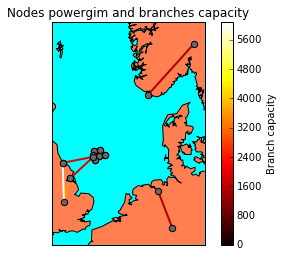

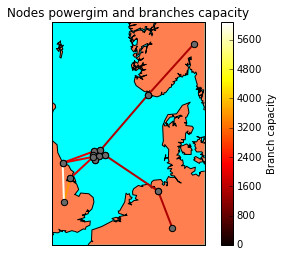

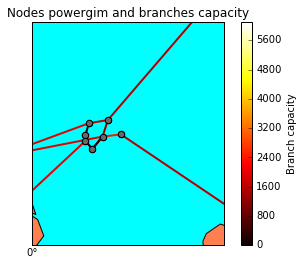

In [20]:
#import ipyleaflet
#import folium
res.plotMapGrid(nodetype='powergim',branchtype='capacity') # Stage 1
res2.plotMapGrid(nodetype='powergim',branchtype='capacity') # Stage 2
res2.plotMapGrid(nodetype='powergim',branchtype='capacity', latlon=[53,0,57,6],draw_par_mer=True) # Stage 2